In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load data

In [5]:
from glob import glob
history_files = {
    'ne4np4': glob('data/*.cam.h1.*'),
    #'ne4np4': glob('/global/homes/b/bhillma/codes/e3sm/cases/master.FC5AV1C-L.ne4_ne4.cori-knl_intel.16x1.20190430-0930/run/*.cam.h1.*'),
    #'ne30np4': glob('/project/projectdirs/m3312/crjones/e3sm/earlyscience.FC5AV1C-L.ne30.sp1_64x1_1000m.20190415/*.cam.h0.*'),
    #'ne120np4': glob('/project/projectdirs/m3312/crjones/e3sm/early_science/monthly_hist/*.cam.h0.*'),
    #'ne512np4': glob('/global/homes/b/bhillma/codes/e3sm/cases/add-ne512-grids.FC5AV1C-H01A.ne512np4_360x720cru_oRRS15to5.cori-knl_intel.1024x17x8.20190501-0838/run/*.cam.h1.*'),
}
grid_files = {
    'ne4np4': 'data/ne4np4-pentagons_c100308.nc',
    #'ne4np4': '/project/projectdirs/acme/mapping/grids/ne4np4-pentagons_c100308.nc',
    #'ne30np4': '/project/projectdirs/acme/mapping/grids/ne30np4_pentagons.091226.nc',
    #'ne120np4': '/project/projectdirs/acme/mapping/grids/ne120np4_pentagons.100310.nc',
    #'ne512np4': '/project/projectdirs/acme/mapping/grids/ne512np4_scrip_c20190125.nc',
}

from xarray import open_dataset
datasets = {c: open_dataset(history_files[c][0], decode_times=False) for c in history_files.keys()}
grids = {c: open_dataset(grid_files[c]) for c in grid_files.keys()}

In [6]:
# Read data we will use for all examples below
case = 'ne4np4'
variable_name = 'PS'
data = datasets[case][variable_name].isel(time=0)
xv = grids[case]['grid_corner_lon'].rename({'grid_size': 'ncol'})
yv = grids[case]['grid_corner_lat'].rename({'grid_size': 'ncol'})

lon = datasets[case]['lon']
lat = datasets[case]['lat']

# Drawing patches on the native grid

In [66]:
from matplotlib import pyplot
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from cartopy import crs
import numpy

def plot_unstructured(xv, yv, data, antialiased=False, **kwargs):
    """
    Plot unstructured data. xv and yv specify the x and y coordinates
    of the vertices of each cell and should have shape [ni,nv] where ni
    is the size of the grid (number of cells) and nv is the number of
    vertices for each cell. Data contains the values of the data you
    want to plot, and should have dimension [ni,]. The intent with this
    function is that you will need to read in an auxillary SCRIP-format
    file that describes the grid (unless this information is present in
    the same file that contains the data; unlikely) as well as the file
    that contains the data, and grab the cell corner information from
    the SCRIP file and the data from the data file. This function will
    then plot the data on the native grid by looping over each cell and
    drawing patches for each. Note that this will probably be really
    slow for big grids! Seems to work alright up to about ne120 or so,
    but really some more clever techniques should probably be used here
    (parallelism?).
    
    NOTE: To avoid artifacts due to antialiasing, you should probably pass
    antialiaseds=False to **kwargs.
    """
    patches = []
    colors = []
    for i in range(xv.shape[0]):

        # Find vertices for this cell (as [x, y] pairs)
        corners = []
        xvals = xv.values[i,:]
        yvals = yv.values[i,:]

        # Fix stuff that wraps around; I should NOT have to do this
        # if I'm using cartopy!
        if any(xvals < 90) and any(xvals > 270):
            xvals = numpy.where(xvals < 90, xvals + 360, xvals)
        if any(yvals < -45) and any(yvals > 45):
            yvals = numpy.where(yvals < -45, yvals + 90, yvals)
        
        # Loop over corners
        for iv in range(xv.shape[1]):
            corners.append([xvals[iv], yvals[iv]])

        # Add PathPatch for this cell
        path = Path(corners, closed=False)
        patch = PathPatch(path)
        patches.append(patch)
        colors.append(data.values[i])
        
    # Create a PatchCollection from our aggregated list of PathPatches
    p = PatchCollection(patches, antialiaseds=antialiased, **kwargs)
    
    # Color the patches in the collection according to the data values
    #colors = data.squeeze()
    p.set_array(numpy.array(colors))

    # Add the collection to the axes
    ax = pyplot.gca()
    ax.add_collection(p)

    # Set sane axes limits
    #ax.set_xlim([xv.min(), xv.max()])
    #ax.set_ylim([yv.min(), yv.max()])
    ax.autoscale()
    
    # Return collection of patches
    return p

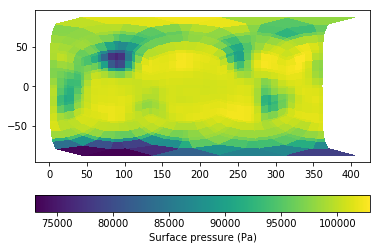

In [67]:
#%%timeit
figure, ax = pyplot.subplots()
pl = plot_unstructured(xv, yv, data)
cb = pyplot.colorbar(pl, orientation='horizontal', label='%s (%s)'%(data.long_name, data.units))
#pyplot.close()

In [72]:
from matplotlib import pyplot
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection, PolyCollection
from cartopy import crs
import numpy

def plot_unstructured(xv, yv, data, antialiased=False, **kwargs):
    """
    Plot unstructured data. xv and yv specify the x and y coordinates
    of the vertices of each cell and should have shape [ni,nv] where ni
    is the size of the grid (number of cells) and nv is the number of
    vertices for each cell. Data contains the values of the data you
    want to plot, and should have dimension [ni,]. The intent with this
    function is that you will need to read in an auxillary SCRIP-format
    file that describes the grid (unless this information is present in
    the same file that contains the data; unlikely) as well as the file
    that contains the data, and grab the cell corner information from
    the SCRIP file and the data from the data file. This function will
    then plot the data on the native grid by looping over each cell and
    drawing patches for each. Note that this will probably be really
    slow for big grids! Seems to work alright up to about ne120 or so,
    but really some more clever techniques should probably be used here
    (parallelism?).
    
    NOTE: To avoid artifacts due to antialiasing, you should probably pass
    antialiaseds=False to **kwargs.
    """
   
    # Create array of cell vertices, indexed [npoints, ncorners, 2]
    corners = numpy.stack([xv.values, yv.values], axis=2)
    
    # Go back and fix corners where they wrap
    for i in range(corners.shape[0]):

        # Fix stuff that wraps around; I should NOT have to do this
        # if I'm using cartopy!
        if any(corners[i,:,0] < 90) and any(corners[i,:,0] > 270):
            corners[i,:,0] = numpy.where(corners[i,:,0] < 90, corners[i,:,0] + 360, corners[i,:,0])
        if any(corners[i,:,1] < -45) and any(corners[i,:,1] > 45):
            corners[i,:,1] = numpy.where(corners[i,:,1] < -45, corners[i,:,1] + 90, corners[i,:,1])
            
    # Create a PatchCollection from our aggregated list of PathPatches
    p = PolyCollection(corners, array=data, antialiaseds=False, **kwargs)

    # Add the collection to the axes
    ax = pyplot.gca()
    ax.add_collection(p)

    # Set sane axes limits
    ax.set_xlim([xv.values.min(), xv.values.max()])
    ax.set_ylim([yv.values.min(), yv.values.max()])
    
    # Return collection of patches
    return p

In [73]:
%%timeit
from cartopy import crs
figure, ax = pyplot.subplots()
pl = plot_unstructured(xv, yv, data, antialiased=False)
cb = pyplot.colorbar(pl, orientation='horizontal', label='%s (%s)'%(data.long_name, data.units))
pyplot.close()

51.6 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
a = numpy.stack([xv.values, yv.values], axis=2)
a.shape

(866, 5, 2)

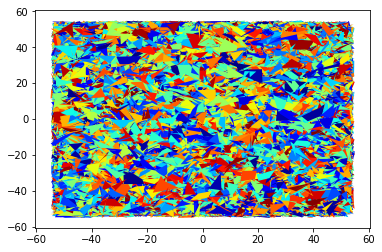

(200000, 5, 2)
(200000,)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import matplotlib

npol, nvrts = 200000, 5
cnts = 100 * (np.random.random((npol,2)) - 0.5)
offs = 10 * (np.random.random((nvrts,npol,2)) - 0.5)
vrts = cnts + offs
vrts = np.swapaxes(vrts, 0, 1)
z = np.random.random(npol) * 500

fig, ax = plt.subplots()
coll = PolyCollection(vrts, array=z, cmap=matplotlib.cm.jet)
ax.add_collection(coll)
ax.autoscale()
plt.show()

print(vrts.shape)
print(z.shape)

In [24]:
vrts

array([[[-2.13402523e+01, -2.91357007e+01],
        [-2.48219266e+01, -3.11465172e+01],
        [-2.52588493e+01, -2.38942193e+01],
        [-2.18646741e+01, -3.06108036e+01],
        [-2.54300118e+01, -2.71927642e+01]],

       [[-2.92182495e+01,  5.39300240e-01],
        [-2.96285959e+01, -4.86741997e+00],
        [-3.32565659e+01, -3.41644425e+00],
        [-2.59415510e+01, -3.45159658e-02],
        [-3.37076764e+01, -4.23386632e+00]],

       [[ 4.95169544e+01,  4.41058701e+01],
        [ 4.71051424e+01,  4.24507458e+01],
        [ 4.62989566e+01,  4.86113860e+01],
        [ 5.06898147e+01,  4.58436581e+01],
        [ 5.13272253e+01,  4.63147198e+01]],

       ...,

       [[-1.12268793e+01,  3.97165228e+01],
        [-1.08047646e+01,  3.86409723e+01],
        [-1.31712939e+01,  3.93241102e+01],
        [-1.16316210e+01,  4.37659631e+01],
        [-1.38373445e+01,  4.62022360e+01]],

       [[-4.07514384e+01,  1.48386451e+01],
        [-3.82029435e+01,  1.48739063e+01],
        [-4

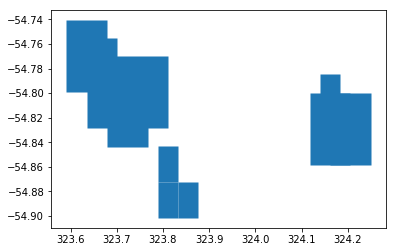

In [17]:
import numpy as np
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Cell lat/lon centers:
lons = np.array([ 323.811,  323.854,  323.811,  323.723, 324.162,  324.206,  323.723,  324.162, 323.635,  323.679])
lats = np.array([-54.887, -54.887, -54.858, -54.829, -54.829, -54.829, -54.799, -54.799, -54.770, -54.770])

# Cell size scaling factors:
cx = np.array([1,1,1,2,2,2,4,1,2,1]) 
cy = np.array([1,1,1,1,2,2,2,1,2,1])

# Smallest cell sizes:
min_dlon = 0.0439453  
min_dlat = 0.0292969 

# Calculate cell sizes based on cell scaling factor and smallest cell size
dlon = cx * min_dlon
dlat = cy * min_dlat

# calculate cell extnets....
x1 = lons - 0.5 * dlon
x2 = lons + 0.5 * dlon
y1 = lats - 0.5 * dlat
y2 = lats + 0.5 * dlat

# ... and corners
c1 = np.array([x1,y1]).T
c2 = np.array([x2,y1]).T
c3 = np.array([x2,y2]).T
c4 = np.array([x1,y2]).T

# Now loop over cells and create Patch objects from the cell corners.
# This is the bottleneck as it using a slow Python loop instead of 
# fast numpy broadcasting. How can I speed this up?
ncel = np.alen(lons)
patches = []
for i in np.arange(ncel):
    verts = np.vstack([c1[i], c2[i], c3[i], c4[i]])
    p = plt.Polygon(verts)
    patches.append(p)

# Create patch collection from list of Patches
p = PatchCollection(patches, match_original=True)

ax.add_collection(p)
ax.autoscale()
plt.show()

# Matplotlib Delauney triangulation

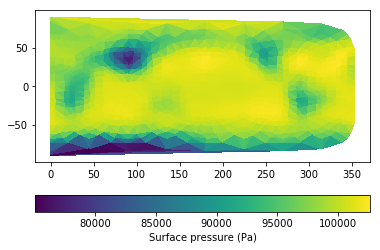

In [7]:
#%%timeit
figure, ax = pyplot.subplots()
pl = ax.tripcolor(lon, lat, data)
cb = pyplot.colorbar(pl, orientation='horizontal', label='%s (%s)'%(data.long_name, data.units))
#pyplot.close()

# Regridding online using griddata

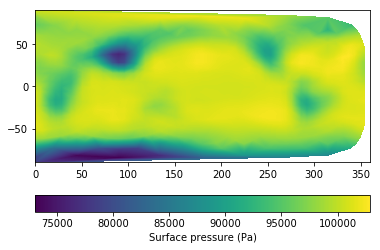

In [8]:
#%%timeit

# Define new grid
xi = numpy.linspace(0, 360, 360*16)
yi = numpy.linspace(-90, 90, 180*16)

# Interpolate to new grid
from scipy.interpolate import griddata
data_regridded = griddata((lon, lat), data, (xi[None,:], yi[:,None]), method='linear')

# Plot on new grid
figure, ax = pyplot.subplots()
pl = ax.pcolormesh(xi, yi, data_regridded)
cb = pyplot.colorbar(pl, orientation='horizontal', label='%s (%s)'%(data.long_name, data.units))

#pyplot.close()

# Timing results

In [92]:
ne = (4, 30, 120)
native = (212e-3, 10.1, 134)
delauney = (93e-3, 3.55, 47.7)
griddata_4degree = (51e-3, 952e-3, 12.2)
griddata_1degree = (50.7e-3, 672e-3, 12.2)
griddata_05degree = (69.6e-3, 709e-3, 13.2)
griddata_0125degree = (681e-3, 1.48, 16.8)
griddata_00625degree = (2.65, 3.48, 15.7)

Text(0, 0.5, 'Time to plot (s)')

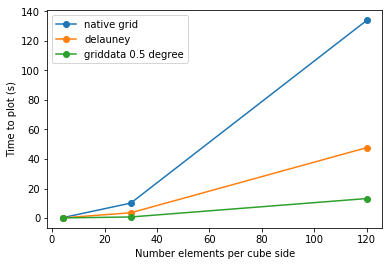

In [94]:
figure, ax = pyplot.subplots()
pl = ax.plot(ne, native, 'o-', label='native grid')
pl = ax.plot(ne, delauney, 'o-', label='delauney')
#pl = ax.plot(ne, griddata_4degree, 'o-', label='griddata 4 degree')
#pl = ax.plot(ne, griddata_1degree, 'o-', label='griddata 1 degree')
pl = ax.plot(ne, griddata_05degree, 'o-', label='griddata 0.5 degree')
pyplot.legend()
ax.set_xlabel('Number elements per cube side')
ax.set_ylabel('Time to plot (s)')

In [5]:
def plot_map_native(lon_corners, lat_corners, data, **kwargs):
    from matplotlib import pyplot, patches, path
    import numpy
    
    # Fix longitude coordinates; we need longitudes to run from
    # -180 to 180, not from 0 to 360
    lon_corners.values = numpy.where(lon_corners > 180, lon_corners - 360, lon_corners)

    # Loop over GLL nodes and create paths that describe the boundaries
    # of each node; collect these into a list to plot all at once
    path_list = []
    for icol in range(lon_corners.shape[0]):

        # Get corners for this node
        x_corners = lon_corners[icol,:].values
        y_corners = lat_corners[icol,:].values

        # Repeat first vertex at end of array to close the path
        x_corners = numpy.append(x_corners, x_corners[0])
        y_corners = numpy.append(y_corners, y_corners[0])

        # Create paths connecting the corners and append to list
        vertices = numpy.column_stack([x_corners, y_corners])
        path_list.append(path.Path(vertices, closed=True))

    # Plot collection of patches
    from matplotlib.collections import PathCollection
    collection = PathCollection(path_list, transform=crs.Geodetic(), **kwargs)
    collection.set_array(data)

    ax = pyplot.gca()
    pl = ax.add_collection(collection)

    return pl

In [17]:
%%timeit
from cartopy import crs
figure, ax = pyplot.subplots(subplot_kw=dict(projection=crs.PlateCarree()))
pl = plot_map_native(xv, yv, data, antialiased=False)
#ax.coastlines()
ax.set_xlim(-180, 180)
ax.set_ylim(-90,90)
pyplot.close()

1min 39s ± 2.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
